In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

# Suppress tensorflow logging due to un-relevant warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
training_split = 19000
validation_split = 4750
test_split = 2640 

asset_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'HeroysundBridge-ML-Assets'))
df = pd.read_parquet(os.path.join(asset_folder, 'silver','combined_data_v01.parquet'))
df.index = pd.to_datetime(df['Date'], format='%Y%m%d%H')
df = df['2020-10-01 00:00:00':]

# Naive Prediction (t + 1)

Reference: isbn = {1492078190}, title = {AI and Machine Learning for Coders: A Programmer's Guide to Artificial Intelligence}, author = {Moroney, Laurence}, Page(s): 169-171

(2640, 1)
(2640, 1)


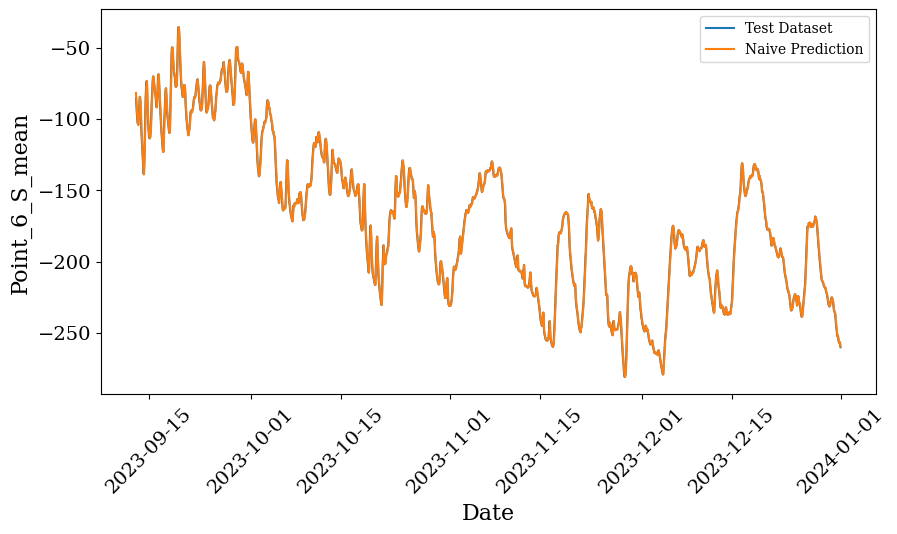

MSE: 5.445536740779278
MAE: 1.733630897262175
R2: 0.9981437554573079


In [4]:
delay = 1
test_df = df[['Point_6_S_mean']][(training_split + validation_split):]

naive_df = df[['Point_6_S_mean']][((training_split + validation_split) - delay):-delay]
print(naive_df.shape)

plt.figure(figsize=(10, 5))
plt.plot(test_df.index, test_df['Point_6_S_mean'], label='Test Dataset')
plt.plot(test_df.index, naive_df['Point_6_S_mean'], label='Naive Prediction')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Point_6_S_mean', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend()
plt.show()

print(f"MSE: {mean_squared_error(test_df['Point_6_S_mean'], naive_df['Point_6_S_mean']).numpy()}")
print(f"MAE: {mean_absolute_error(test_df['Point_6_S_mean'], naive_df['Point_6_S_mean']).numpy()}")
print(f"R2: {score(test_df['Point_6_S_mean'], naive_df['Point_6_S_mean'])}")

# Sckit-learn linear regression model

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

**Bare eksponert på test settet**

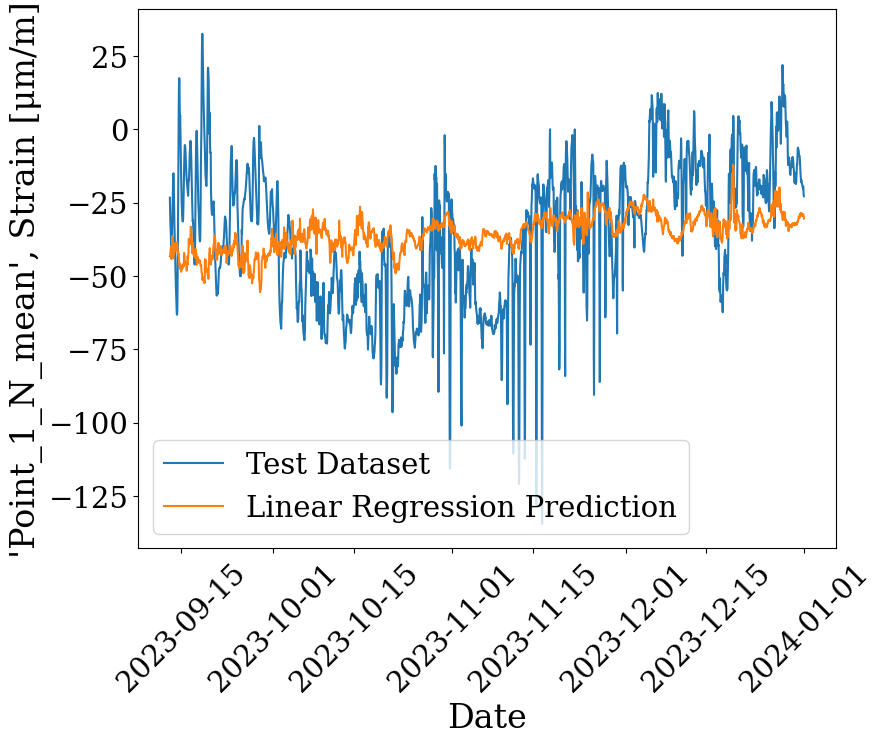

MSE: 531.0537921063897
MAE: 18.779873642863173
R^2: 0.06233643379696718


In [5]:
lin_reg_df = df[-test_split:]

model = LinearRegression()

# Split the data into features (X) and target variable (y)
X = lin_reg_df[['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]
y = lin_reg_df['Point_1_N_mean']

X_test = lin_reg_df[['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]#'Average_Global_Radiation_(1h)',
y_test = lin_reg_df['Point_1_N_mean']

model.fit(X, y)
predictions = model.predict(X_test)

plt.figure(figsize=(9, 7))
plt.plot(lin_reg_df.index, y_test, label='Test Dataset')
plt.plot(lin_reg_df.index, predictions, label='Linear Regression Prediction')
plt.xlabel('Date', fontsize=16*1.5)
plt.ylabel("'Point_1_N_mean', Strain [μm/m]", fontsize=16*1.5)
plt.xticks(rotation=45)
plt.yticks(fontsize=14*1.5)
plt.xticks(fontsize=14*1.5)
plt.legend(fontsize=14*1.5)
plt.show()

print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"R^2: {model.score(X_test, y_test)}")

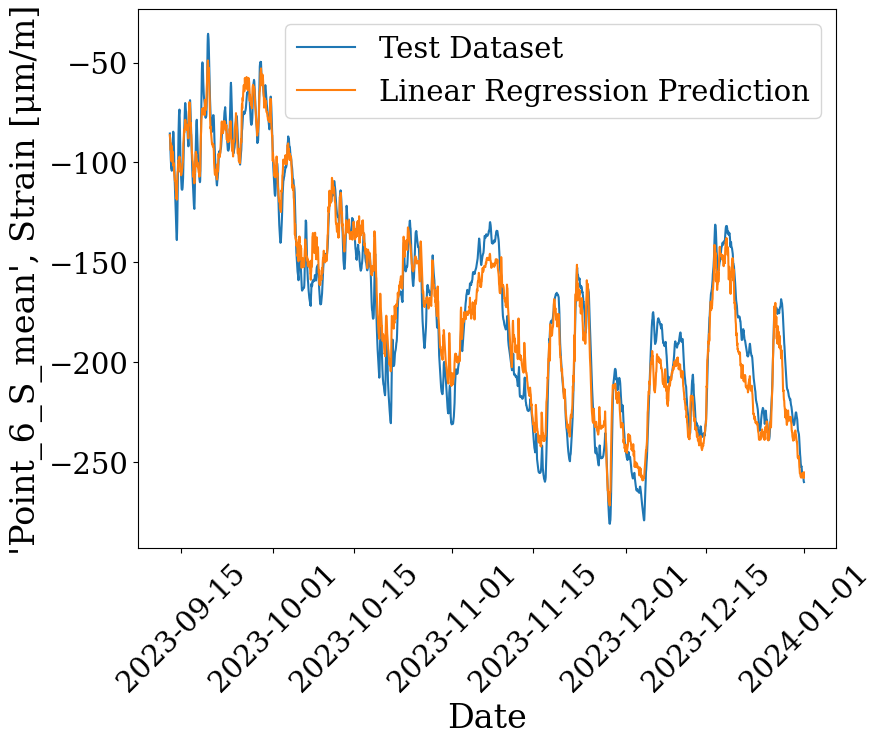

MSE: 143.30845568730936
MAE: 10.039803778753633
R^2: 0.9511498036916871


In [6]:
lin_reg_df = df[-test_split:]

model = LinearRegression()

# Split the data into features (X) and target variable (y)
X = lin_reg_df[['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]
y = lin_reg_df['Point_6_S_mean']

X_test = lin_reg_df[['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]#'Average_Global_Radiation_(1h)',
y_test = lin_reg_df['Point_6_S_mean']

model.fit(X, y)
predictions = model.predict(X_test)

plt.figure(figsize=(9, 7))
plt.plot(lin_reg_df.index, y_test, label='Test Dataset')
plt.plot(lin_reg_df.index, predictions, label='Linear Regression Prediction')
plt.xlabel('Date', fontsize=16*1.5)
plt.ylabel("'Point_6_S_mean', Strain [μm/m]", fontsize=16*1.5)
plt.xticks(rotation=45)
plt.yticks(fontsize=14*1.5)
plt.xticks(fontsize=14*1.5)
plt.legend(fontsize=14*1.5)
plt.show()

print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"R^2: {model.score(X_test, y_test)}")

**Trent på data før test split**

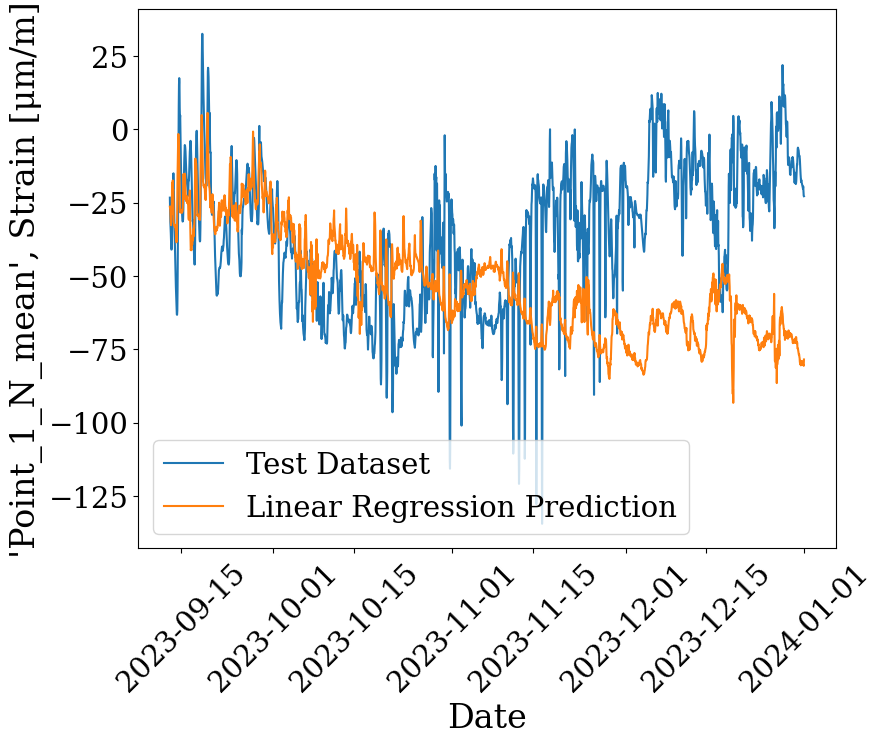

MSE: 1358.4654030675915
MAE: 29.869620904978014
R^2: -1.398596024239692


In [7]:
lin_reg_df1 = df[:-test_split]
lin_reg_df2 = df[-test_split:]

model = LinearRegression()

# Split the data into features (X) and target variable (y)
X = lin_reg_df1[['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]
y = lin_reg_df1['Point_1_N_mean']

X_test = lin_reg_df2[['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]#'Average_Global_Radiation_(1h)',
y_test = lin_reg_df2['Point_1_N_mean']

model.fit(X, y)
predictions = model.predict(X_test)

plt.figure(figsize=(9,7))
plt.plot(lin_reg_df.index, y_test, label='Test Dataset')
plt.plot(lin_reg_df.index, predictions, label='Linear Regression Prediction')
plt.xlabel('Date', fontsize=16*1.5)
plt.ylabel("'Point_1_N_mean', Strain [μm/m]", fontsize=16*1.5)
plt.xticks(rotation=45)
plt.yticks(fontsize=14*1.5)
plt.xticks(fontsize=14*1.5)
plt.legend(fontsize=14*1.5)
plt.show()

print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"R^2: {model.score(X_test, y_test)}")

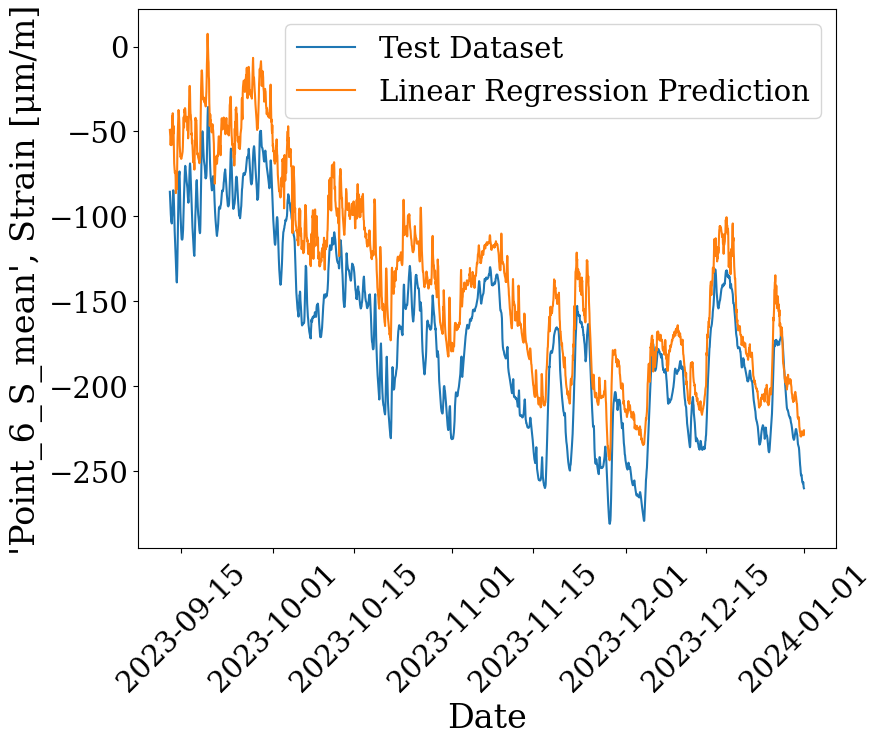

MSE: 1313.2043709977343
MAE: 33.759818185569856
R^2: 0.5523621337728595


In [8]:
lin_reg_df1 = df[:-test_split]
lin_reg_df2 = df[-test_split:]

model = LinearRegression()

# Split the data into features (X) and target variable (y)
X = lin_reg_df1[['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]
y = lin_reg_df1['Point_6_S_mean']

X_test = lin_reg_df2[['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]#'Average_Global_Radiation_(1h)',
y_test = lin_reg_df2['Point_6_S_mean']

model.fit(X, y)
predictions = model.predict(X_test)

plt.figure(figsize=(9,7))
plt.plot(lin_reg_df.index, y_test, label='Test Dataset')
plt.plot(lin_reg_df.index, predictions, label='Linear Regression Prediction')
plt.xlabel('Date', fontsize=16*1.5)
plt.ylabel("'Point_6_S_mean', Strain [μm/m]", fontsize=16*1.5)
plt.xticks(rotation=45)
plt.yticks(fontsize=14*1.5)
plt.xticks(fontsize=14*1.5)
plt.legend(fontsize=14*1.5)
plt.show()

print(f"MSE: {mean_squared_error(y_test, predictions)}")
print(f"MAE: {mean_absolute_error(y_test, predictions)}")
print(f"R^2: {model.score(X_test, y_test)}")

# Moving average

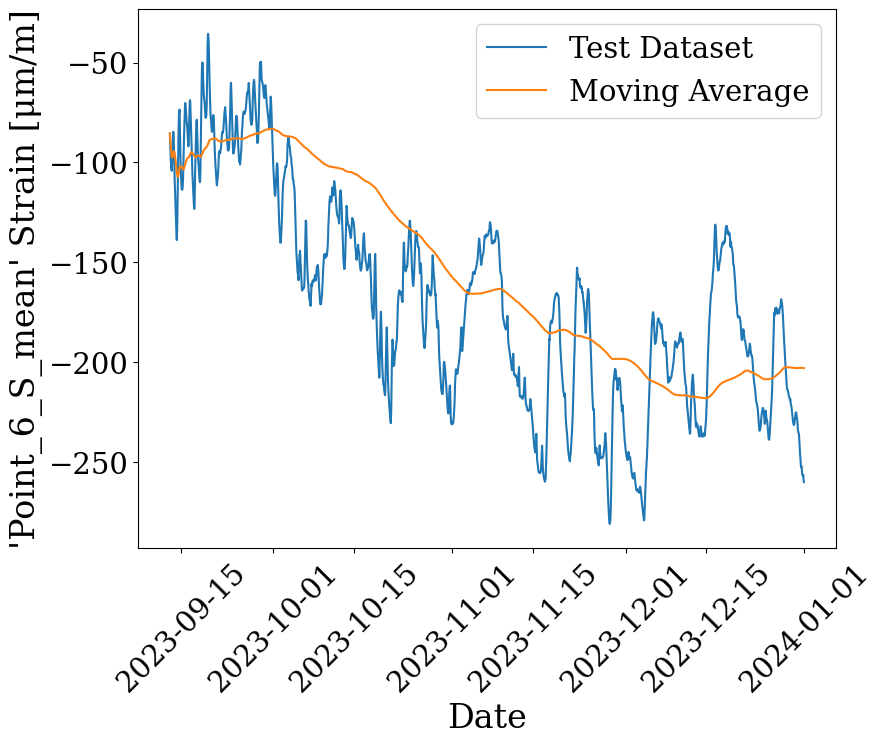

MSE: 1516.0903289268326
MAE: 31.87001186371416
R2: 0.4832034869539875


In [9]:
window = 24 * 30

moving_avg = df[(training_split + validation_split):][['Point_6_S_mean']].rolling(window=window, min_periods=1).mean().dropna()
test_df = df[(training_split + validation_split):][['Point_6_S_mean']].dropna()

plt.figure(figsize=(9, 7))
plt.plot(test_df.index, test_df['Point_6_S_mean'], label='Test Dataset')
plt.plot(moving_avg.index, moving_avg['Point_6_S_mean'], label='Moving Average')
plt.xlabel('Date', fontsize=16*1.5)
plt.ylabel("'Point_6_S_mean' Strain [μm/m]", fontsize=16*1.5)
plt.xticks(rotation=45)
plt.yticks(fontsize=14*1.5)
plt.xticks(fontsize=14*1.5)
plt.legend(fontsize=14*1.5)
plt.show()

mse = mean_squared_error(test_df['Point_6_S_mean'], moving_avg['Point_6_S_mean'].to_numpy())
mae = mean_absolute_error(test_df['Point_6_S_mean'], moving_avg['Point_6_S_mean'].to_numpy())

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {score(test_df['Point_6_S_mean'], moving_avg['Point_6_S_mean'])}")

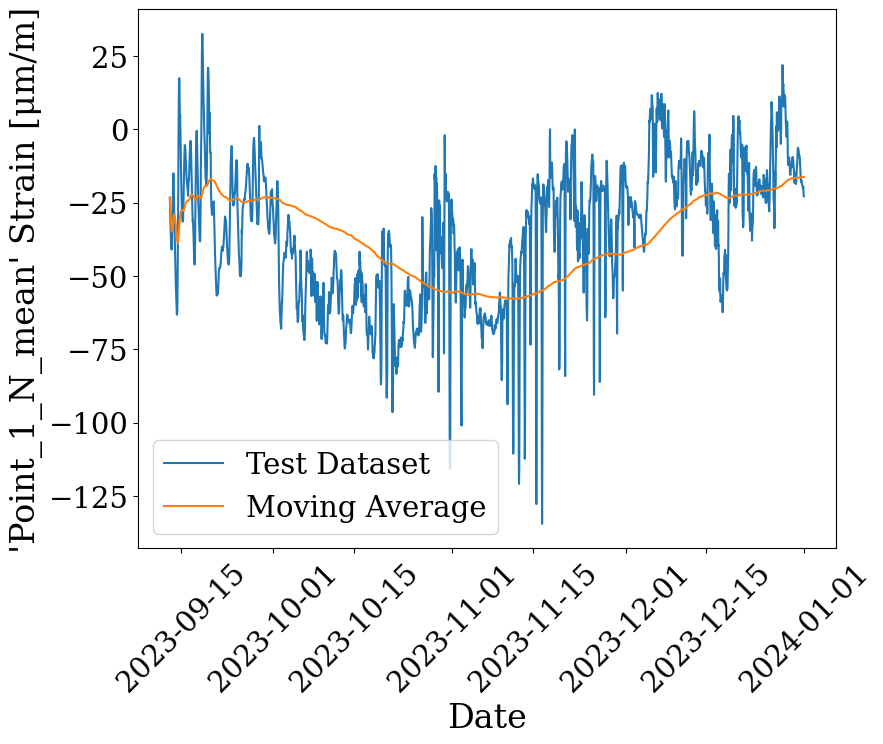

MSE: 453.23181952459424
MAE: 17.41719319090618
R2: 0.1997440362369517


In [10]:
window = 24 * 30

moving_avg = df[(training_split + validation_split):][['Point_1_N_mean']].rolling(window=window, min_periods=1).mean().dropna()
test_df = df[(training_split + validation_split):][['Point_1_N_mean']].dropna()

plt.figure(figsize=(9, 7))
plt.plot(test_df.index, test_df['Point_1_N_mean'], label='Test Dataset')
plt.plot(moving_avg.index, moving_avg['Point_1_N_mean'], label='Moving Average')
plt.xlabel('Date', fontsize=16*1.5)
plt.ylabel("'Point_1_N_mean' Strain [μm/m]", fontsize=16*1.5)
plt.xticks(rotation=45)
plt.yticks(fontsize=14*1.5)
plt.xticks(fontsize=14*1.5)
plt.legend(fontsize=14*1.5)
plt.show()

mse = mean_squared_error(test_df['Point_1_N_mean'], moving_avg['Point_1_N_mean'].to_numpy())
mae = mean_absolute_error(test_df['Point_1_N_mean'], moving_avg['Point_1_N_mean'].to_numpy())

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {score(test_df['Point_1_N_mean'], moving_avg['Point_1_N_mean'])}")

# Seasonal Decomposition

Reference: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose

(Copilot-generated description!!!) Statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

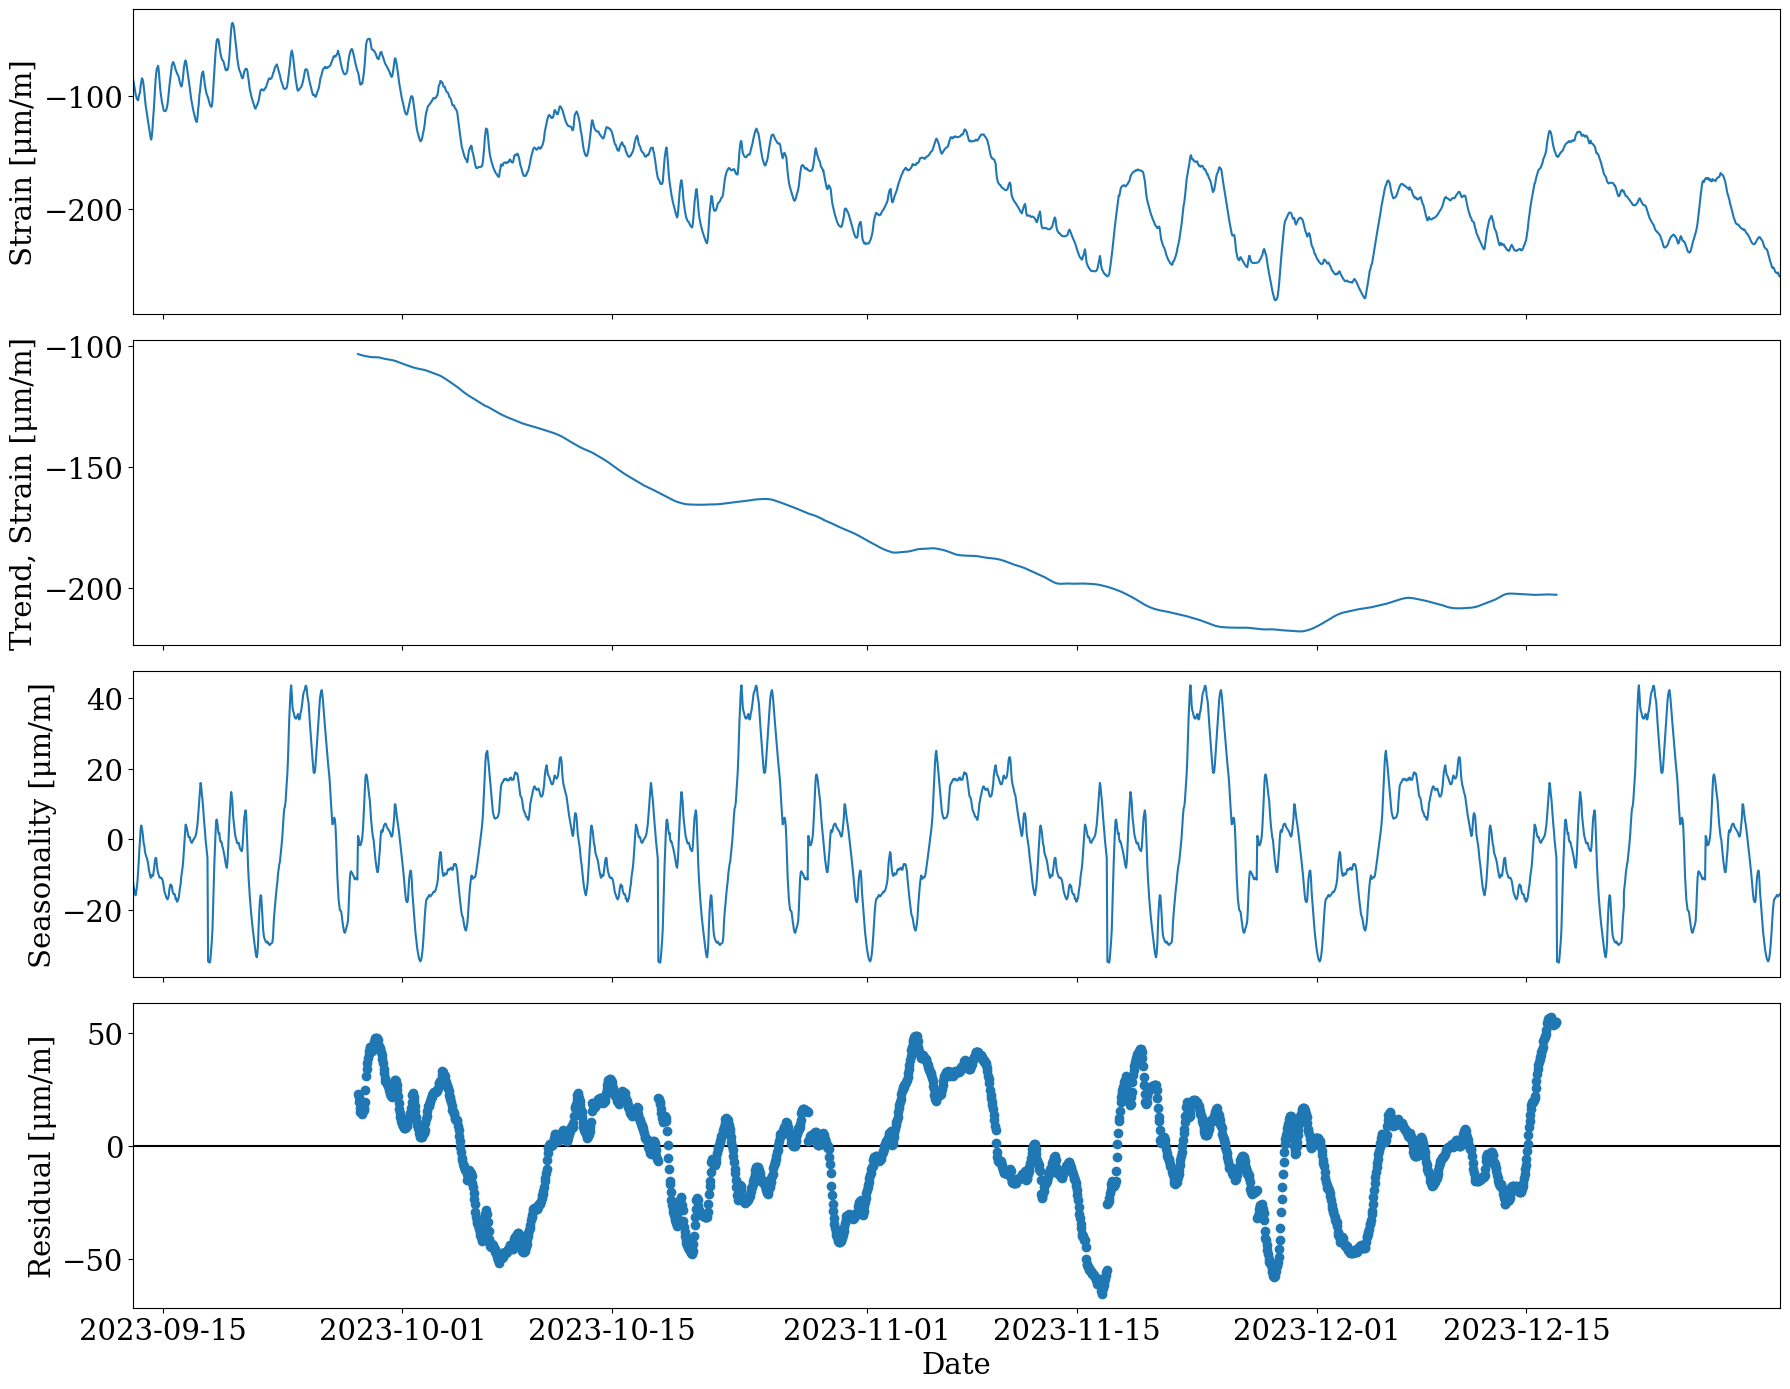

MSE: 909.5626795267409
MAE: 25.31594311701762
R2: 0.5851935362908063


In [11]:
window = 24*30
window_halved = window // 2

# Perform seasonal decomposition on the test dataset
test_df = df[(training_split + validation_split):][['Point_6_S_mean']]  # test_df = df[['Point_6_S_mean']]
seasonal_df = seasonal_decompose(test_df, model='additive', period=window)
fig = seasonal_df.plot()
fig.set_size_inches((18, 14))

# Adjust font size of tick labels and y-axis labels for all subplots
for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=14*1.5)  # adjust tick font size
    ax.set_ylabel(ax.get_ylabel(), fontsize=14*1.5)  # adjust y-axis label font size

# Adjust x-axis label only for the last subplot
fig.get_axes()[-1].set_xlabel('Date', fontsize=14*1.5)
fig.get_axes()[0].set_ylabel("Strain [μm/m]", fontsize=14*1.5)
fig.get_axes()[1].set_ylabel("Trend, Strain [μm/m]", fontsize=14*1.5)
fig.get_axes()[2].set_ylabel("Seasonality [μm/m]", fontsize=14*1.5)
fig.get_axes()[3].set_ylabel("Residual [μm/m]", fontsize=14*1.5)

fig.tight_layout()
plt.show()

# Extract the trend component from the seasonal decomposition
seasonal_trend_df = pd.DataFrame(seasonal_df.trend)
seasonal_trend_df = seasonal_trend_df.dropna()
test_df = test_df[(window//2):-(window//2)]

# plt.figure(figsize=(10, 5))
# plt.plot(seasonal_trend_df.index, test_df, label='Reduced Test Dataset')  # Plotting 'Point_1_N_mean' against the index of seasonal_trend_df
# plt.plot(seasonal_trend_df.index, seasonal_trend_df, label='Trend Component')
# plt.xlabel('Date', fontsize=16)
# plt.ylabel("'Point_6_S_mean' Strain [μm/m]", fontsize=16)
# plt.xticks(rotation=45)
# plt.yticks(fontsize=14)
# plt.xticks(fontsize=14)
# plt.legend()
# plt.show()

print(f"MSE: {mean_squared_error(test_df['Point_6_S_mean'], seasonal_trend_df['trend'])}")
print(f"MAE: {mean_absolute_error(test_df['Point_6_S_mean'], seasonal_trend_df['trend'])}")
print(f"R2: {score(test_df['Point_6_S_mean'], seasonal_trend_df['trend'])}")

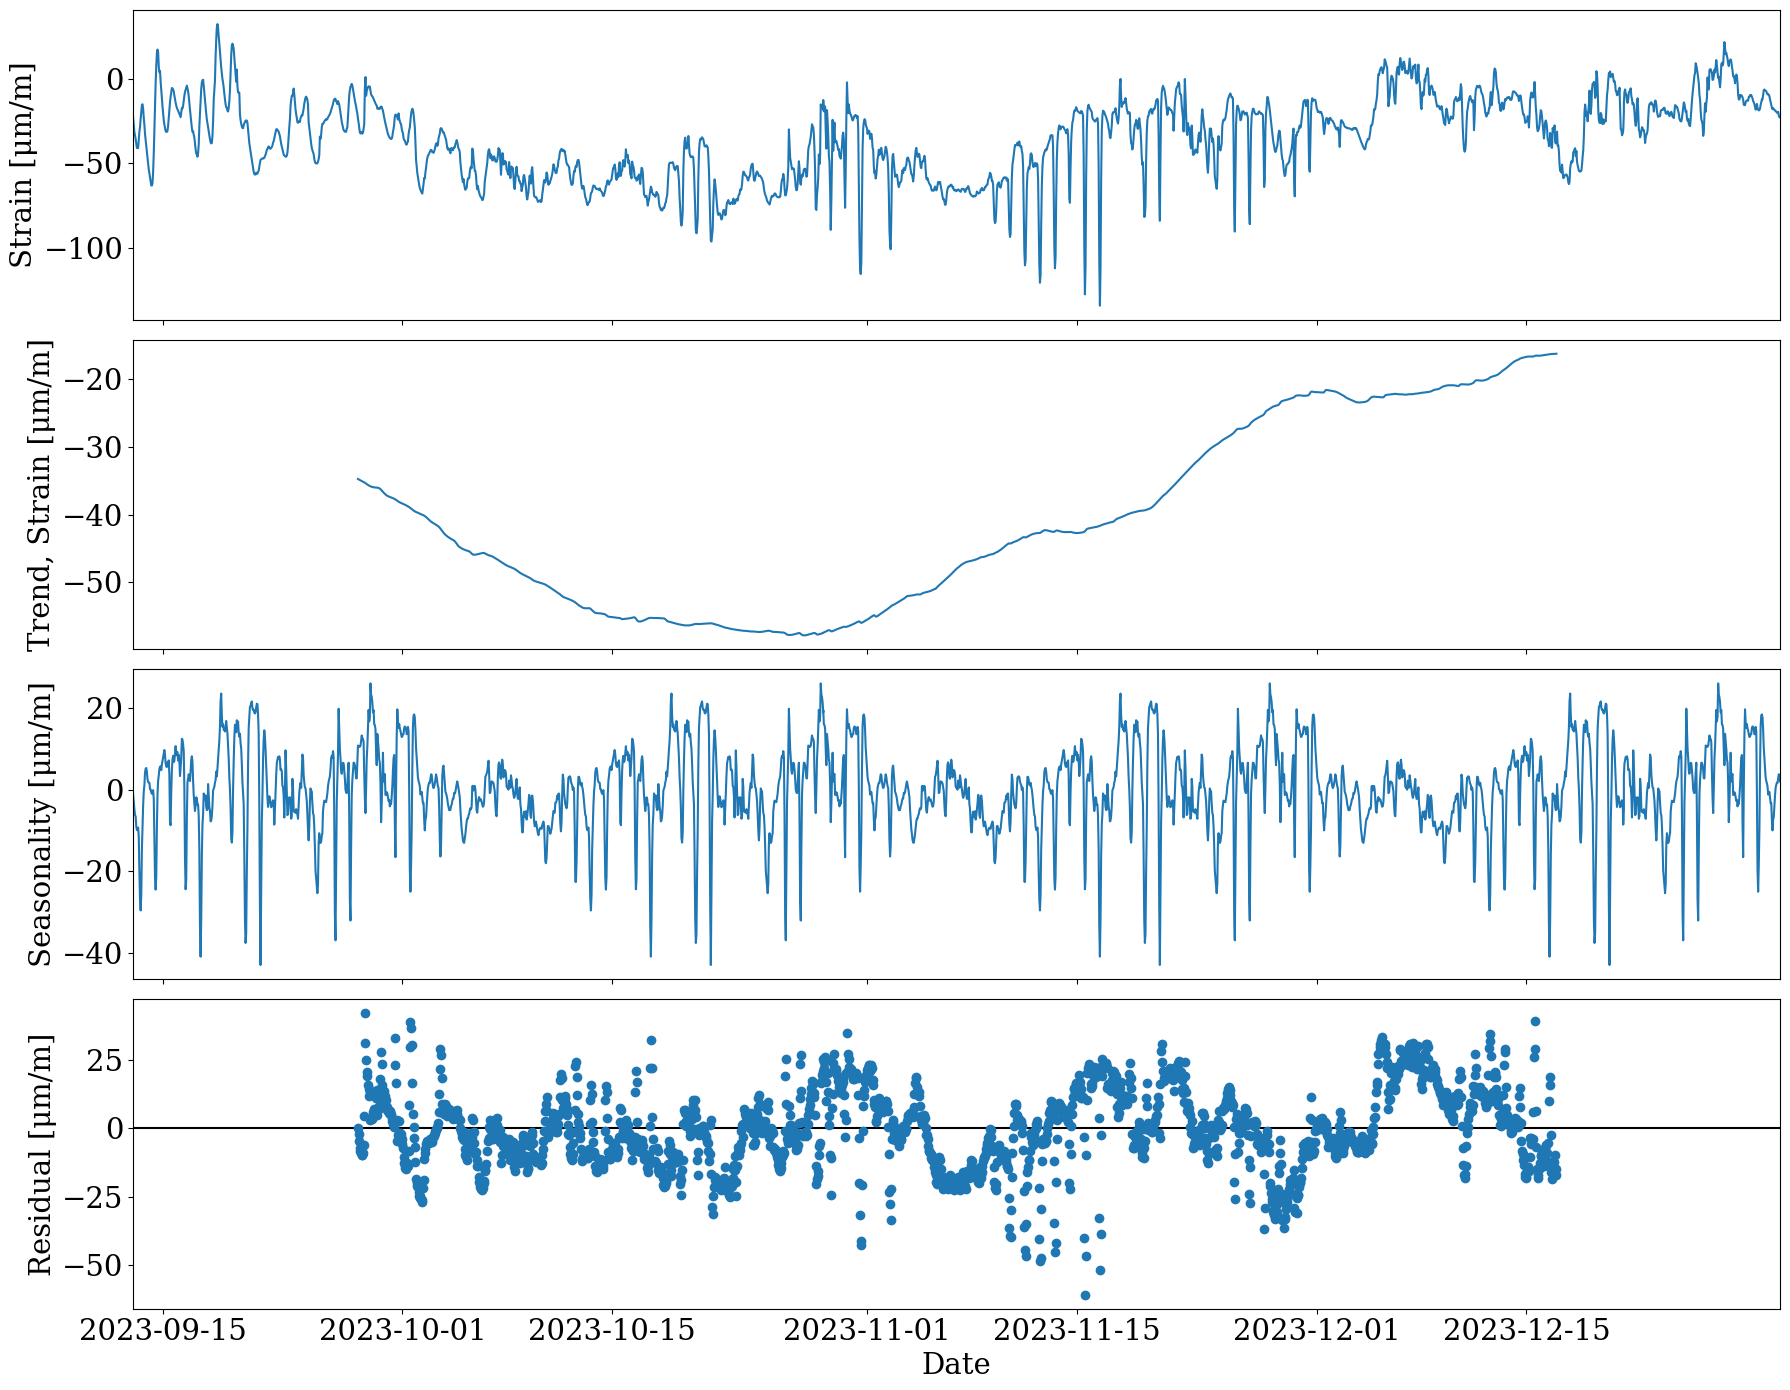

MSE: 304.3723233336881
MAE: 13.542090909234217
R2: 0.44126614036710543


In [12]:
window = 24*30
window_halved = window // 2

# Perform seasonal decomposition on the test dataset
test_df = df[(training_split + validation_split):][['Point_1_N_mean']]  # test_df = df[['Point_6_S_mean']]
seasonal_df = seasonal_decompose(test_df, model='additive', period=window)
fig = seasonal_df.plot()
fig.set_size_inches((18, 14))

# Adjust font size of tick labels and y-axis labels for all subplots
for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=14*1.5)  # adjust tick font size
    ax.set_ylabel(ax.get_ylabel(), fontsize=14*1.5)  # adjust y-axis label font size

# Adjust x-axis label only for the last subplot
fig.get_axes()[-1].set_xlabel('Date', fontsize=14*1.5)
fig.get_axes()[0].set_ylabel("Strain [μm/m]", fontsize=14*1.5)
fig.get_axes()[1].set_ylabel("Trend, Strain [μm/m]", fontsize=14*1.5)
fig.get_axes()[2].set_ylabel("Seasonality [μm/m]", fontsize=14*1.5)
fig.get_axes()[3].set_ylabel("Residual [μm/m]", fontsize=14*1.5)

fig.tight_layout()
plt.show()

# Extract the trend component from the seasonal decomposition
seasonal_trend_df = pd.DataFrame(seasonal_df.trend)
seasonal_trend_df = seasonal_trend_df.dropna()
test_df = test_df[(window//2):-(window//2)]

# plt.figure(figsize=(10, 5))
# plt.plot(seasonal_trend_df.index, test_df, label='Reduced Test Dataset')  # Plotting 'Point_1_N_mean' against the index of seasonal_trend_df
# plt.plot(seasonal_trend_df.index, seasonal_trend_df, label='Trend Component')
# plt.xlabel('Date', fontsize=16)
# plt.ylabel("'Point_6_S_mean' Strain [μm/m]", fontsize=16)
# plt.xticks(rotation=45)
# plt.yticks(fontsize=14)
# plt.xticks(fontsize=14)
# plt.legend()
# plt.show()

print(f"MSE: {mean_squared_error(test_df['Point_1_N_mean'], seasonal_trend_df['trend'])}")
print(f"MAE: {mean_absolute_error(test_df['Point_1_N_mean'], seasonal_trend_df['trend'])}")
print(f"R2: {score(test_df['Point_1_N_mean'], seasonal_trend_df['trend'])}")

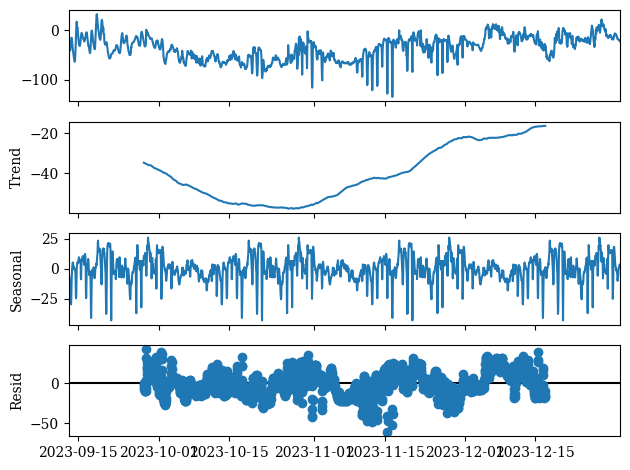

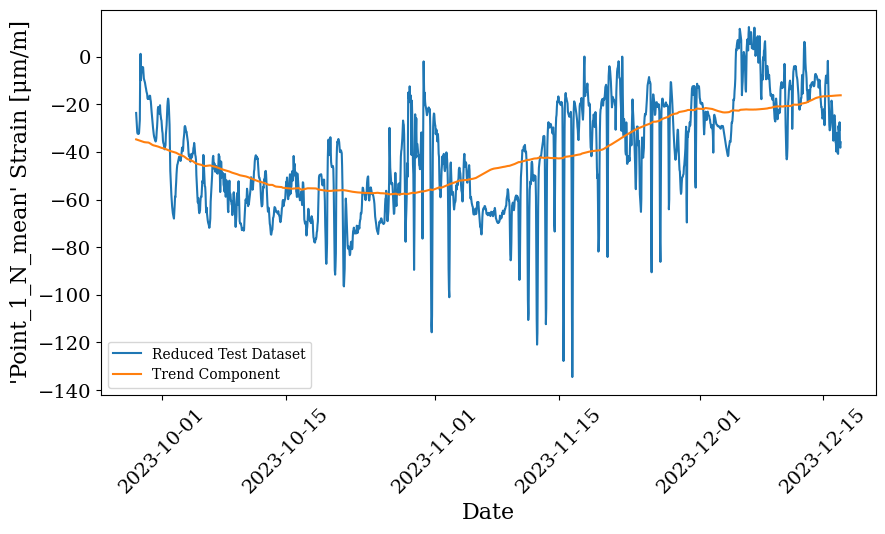

MSE: 304.3723233336881
MAE: 13.542090909234217
R2: 0.44126614036710543


In [13]:
window = 24*30
window_halved = window // 2

# Perform seasonal decomposition on the test dataset
test_df = df[(training_split + validation_split):][['Point_1_N_mean']]
seasonal_df = seasonal_decompose(test_df, model='additive', period=window)
seasonal_df.plot()

# Extract the trend component from the seasonal decomposition
seasonal_trend_df = pd.DataFrame(seasonal_df.trend)
seasonal_trend_df = seasonal_trend_df.dropna()
test_df = test_df[(window//2):-(window//2)]

plt.figure(figsize=(10, 5))
plt.plot(seasonal_trend_df.index, test_df, label='Reduced Test Dataset')  # Plotting 'Point_1_N_mean' against the index of seasonal_trend_df
plt.plot(seasonal_trend_df.index, seasonal_trend_df, label='Trend Component')
plt.xlabel('Date', fontsize=16)
plt.ylabel("'Point_1_N_mean' Strain [μm/m]", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend()
plt.show()

print(f"MSE: {mean_squared_error(test_df['Point_1_N_mean'], seasonal_trend_df['trend'])}")
print(f"MAE: {mean_absolute_error(test_df['Point_1_N_mean'], seasonal_trend_df['trend'])}")
print(f"R2: {score(test_df['Point_1_N_mean'], seasonal_trend_df['trend'])}")

# Augmented Dickey-Fuller test + KPSS test

(GitHub Copilot) {
The KPSS and ADF tests should be applied to the dataset that you are using to train your machine learning model. This is because the purpose of these tests is to help you understand the underlying properties of your data so that you can appropriately preprocess the data and select a suitable model. If your training data is non-stationary, the model you train on this data may not perform well on the test data, even if the test data is from the same non-stationary distribution. This is because many machine learning models, especially linear models and time series models, assume that the data is stationary. Applying the tests to the test set would not be as useful, because you do not use the test set to train your model. The test set is used to evaluate the performance of the model that was trained on the training set. However, if the test set is from a different distribution than the training set, this could indicate a problem with your data splitting method. In summary, apply the KPSS and ADF tests to your training data to check for stationarity before training your model. If the tests indicate that your data is non-stationary, you may need to transform your data to make it stationary before training your model.}

Relevant Article: https://medium.com/@tannyasharma21/comparision-study-of-adf-vs-kpss-test-c9d8dec4f62a

Reference: https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

The Augmented Dickey-Fuller Test is used to determine if time-series data is stationary or not. Similar to a t-test, we set a significance level before the test and make conclusions on the hypothesis based on the resulting p-value. "Another point to remember is the ADF test is fundamentally a statistical significance test" - Selva Prabhakaran (https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)


Reference: https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/

In [14]:
# (Info!) This cell is heavily influenced by GitHub Copilot

# ADF Test
print('Results of Augmented Dickey-Fuller Test (ADF):')
dftest_adf = adfuller(df['Point_1_N_mean'], autolag='AIC')  # Choosing data that ML model has seen (Excluding test data) # [:(validation_split + test_split)]

# Create a Series to hold the ADF test results
adf_output = pd.Series(dftest_adf[0:4], index=['Test Statistic (ADF)', 'p-value (ADF)', '#Lags Used (ADF)', 'Number of Observations Used (ADF)'])

# Add critical values to the Series
for key, value in dftest_adf[4].items():
    adf_output[f'Critical Value ({key}) (ADF)'] = value

print(adf_output)

# Determine if we reject the null hypothesis based on a significance level of 0.05
if adf_output['p-value (ADF)'] < 0.05:
    print("Reject the null hypothesis (H0) - Data is stationary (ADF)")
else:
    print("Fail to reject the null hypothesis (H0) - Data is non-stationary (ADF)")

# KPSS Test
print('\nResults of KPSS Test:')
kpsstest = kpss(df['Point_1_N_mean'], regression='ct', nlags='auto') #[:(validation_split + test_split)]

# Create a Series to hold the KPSS test results
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic (KPSS)', 'p-value (KPSS)', 'Lags Used (KPSS)'])

# Add critical values to the Series
for key, value in kpsstest[3].items():
    kpss_output[f'Critical Value ({key}) (KPSS)'] = value

print(kpss_output)

# Determine if we reject the null hypothesis based on a significance level of 0.05
if kpss_output['p-value (KPSS)'] < 0.05:
    print("Reject the null hypothesis (H0) - Data is non-stationary (KPSS)")
else:
    print("Fail to reject the null hypothesis (H0) - Data is stationary (KPSS)")

Results of Augmented Dickey-Fuller Test (ADF):
Test Statistic (ADF)                -7.766661e+00
p-value (ADF)                        9.149630e-12
#Lags Used (ADF)                     4.800000e+01
Number of Observations Used (ADF)    2.634100e+04
Critical Value (1%) (ADF)           -3.430598e+00
Critical Value (5%) (ADF)           -2.861650e+00
Critical Value (10%) (ADF)          -2.566828e+00
dtype: float64
Reject the null hypothesis (H0) - Data is stationary (ADF)

Results of KPSS Test:
Test Statistic (KPSS)            0.433795
p-value (KPSS)                   0.010000
Lags Used (KPSS)                91.000000
Critical Value (10%) (KPSS)      0.119000
Critical Value (5%) (KPSS)       0.146000
Critical Value (2.5%) (KPSS)     0.176000
Critical Value (1%) (KPSS)       0.216000
dtype: float64
Reject the null hypothesis (H0) - Data is non-stationary (KPSS)


C:\Users\erlih\AppData\Local\Temp\ipykernel_20176\490240985.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(df['Point_1_N_mean'], regression='ct', nlags='auto') #[:(validation_split + test_split)]


In [15]:
# (Info!) This cell is heavily influenced by GitHub Copilot

# ADF Test
print('Results of Augmented Dickey-Fuller Test (ADF):')
dftest_adf = adfuller(df['Point_6_S_mean'], autolag='AIC')  # Choosing data that ML model has seen (Excluding test data)

# Create a Series to hold the ADF test results
adf_output = pd.Series(dftest_adf[0:4], index=['Test Statistic (ADF)', 'p-value (ADF)', '#Lags Used (ADF)', 'Number of Observations Used (ADF)'])

# Add critical values to the Series
for key, value in dftest_adf[4].items():
    adf_output[f'Critical Value ({key}) (ADF)'] = value

print(adf_output)

# Determine if we reject the null hypothesis based on a significance level of 0.05
if adf_output['p-value (ADF)'] < 0.05:
    print("Reject the null hypothesis (H0) - Data is stationary (ADF)")
else:
    print("Fail to reject the null hypothesis (H0) - Data is non-stationary (ADF)")

# KPSS Test
print('\nResults of KPSS Test:')
kpsstest = kpss(df['Point_6_S_mean'], regression='ct', nlags='auto')

# Create a Series to hold the KPSS test results
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic (KPSS)', 'p-value (KPSS)', 'Lags Used (KPSS)'])

# Add critical values to the Series
for key, value in kpsstest[3].items():
    kpss_output[f'Critical Value ({key}) (KPSS)'] = value

print(kpss_output)

# Determine if we reject the null hypothesis based on a significance level of 0.05
if kpss_output['p-value (KPSS)'] < 0.05:
    print("Reject the null hypothesis (H0) - Data is non-stationary (KPSS)")
else:
    print("Fail to reject the null hypothesis (H0) - Data is stationary (KPSS)")

Results of Augmented Dickey-Fuller Test (ADF):
Test Statistic (ADF)                    -5.551167
p-value (ADF)                            0.000002
#Lags Used (ADF)                        49.000000
Number of Observations Used (ADF)    26340.000000
Critical Value (1%) (ADF)               -3.430598
Critical Value (5%) (ADF)               -2.861650
Critical Value (10%) (ADF)              -2.566828
dtype: float64
Reject the null hypothesis (H0) - Data is stationary (ADF)

Results of KPSS Test:
Test Statistic (KPSS)            0.625945
p-value (KPSS)                   0.010000
Lags Used (KPSS)                95.000000
Critical Value (10%) (KPSS)      0.119000
Critical Value (5%) (KPSS)       0.146000
Critical Value (2.5%) (KPSS)     0.176000
Critical Value (1%) (KPSS)       0.216000
dtype: float64
Reject the null hypothesis (H0) - Data is non-stationary (KPSS)


C:\Users\erlih\AppData\Local\Temp\ipykernel_20176\2146739672.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(df['Point_6_S_mean'], regression='ct', nlags='auto')


# SARIMAX  (Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors)

References: 

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html#statsmodels.tsa.statespace.sarimax.SARIMAX

https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

https://pypi.org/project/pmdarima/

(Copilot-generated description!!!) SARIMAX is an acronym for Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model. It is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

In [16]:
a=0 # Varaible to shift how big of training+vaildation set we want to use

data = pd.read_parquet(os.path.join(asset_folder, 'silver','combined_data_v01.parquet'))
data.index = pd.to_datetime(data['Date'], format='%Y%m%d%H').dropna()
data = data[['Point_1_N_mean', 'Average_Global_Radiation_(1h)','PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']][a:-test_split]  #['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']
data['month'] = data.index.month
data['hour'] = data.index.hour
data['day'] = data.index.dayofyear
data.index = pd.to_datetime(data.index)

In [17]:
model = auto_arima(
    data['Point_1_N_mean'],  # The time series to which the ARIMA model is fit.
    exogenous=data[['month', 'hour', 'day', 'Average_Global_Radiation_(1h)','PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']],  # The external variables to include in the model.
    start_p=1,  # This is the order of the AR term.
    start_q=1,  # This is the order of the MA term.
    test='adf',  # The type of unit root test to use in order to determine the order of differencing.
    max_p=3,  # The maximum value of p to try when fitting the model.
    max_q=3,  # The maximum value of q to try when fitting the model.
    m=7,  # The number of periods in each season. This affects the seasonal differencing.
    start_P=0,  # The starting value of P in auto_arima. This is the order of the seasonal AR term.
    seasonal=True,  # Whether to include seasonal differencing in the model.
    d=None,  # The order of first-differencing. If None, the value is automatically determined.
    D=1,  # The order of seasonal differencing.
    trace=True,  # Whether to print status on the fits.
    error_action='ignore',  # If a model cannot be fit, ignore the error and continue.
    suppress_warnings=True,  # If True, do not print warnings.
    stepwise=True,  # If True, use the stepwise algorithm to fit the model.
    maxiter=15  # The maximum number of function evaluations.
)

model.plot_diagnostics(figsize=(15, 12))
plt.show()
model.summary()

Performing stepwise search to minimize aic


KeyboardInterrupt: 

Following code is reused from the following code: https://gist.githubusercontent.com/brendanartley/c69185f28e678c7221546a9c43825ec0/raw/d702ee2d1e4ad57e4ea9f92e5fa09a3414b509e8/gistfile1.txt
Reference: https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

c:\Users\erlih\repos\HeroysundBridge-ML\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\erlih\repos\HeroysundBridge-ML\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


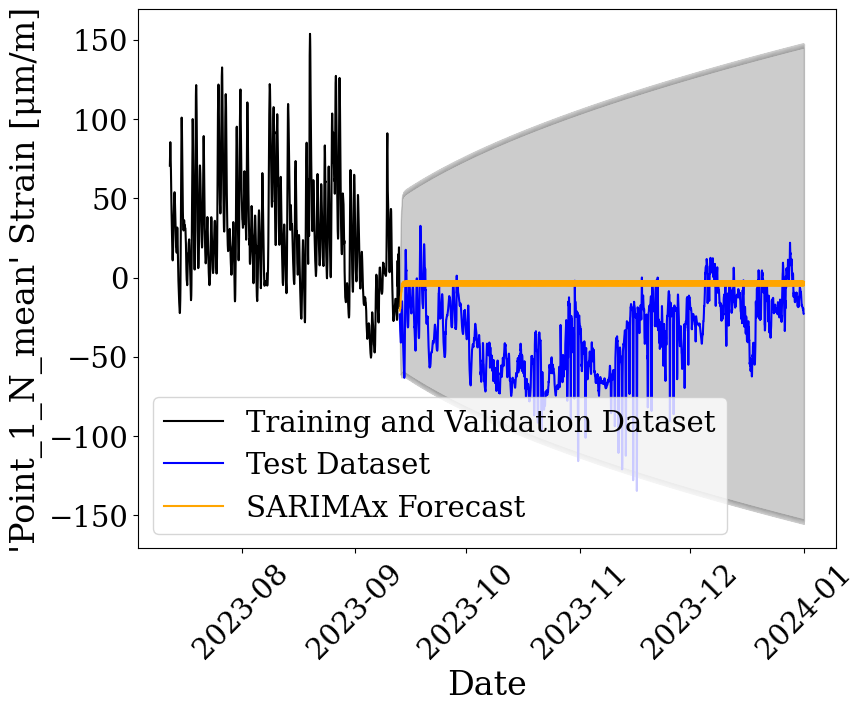

MSE: 1568.7488458701414
MAE: 32.96236953493971
R2: -1.7698863263192766


In [ ]:
def forecast(model, periods=test_split):
    forecast, conf_int = model.predict(n_periods=periods, return_conf_int=True)
    
    forecast_index = pd.date_range(start=data.index[-1], periods=periods + 1, freq='H')[1:]
    lookback_variable = 500*3

    # Plotting
    plt.figure(figsize=(9, 7))
    plt.plot(df.index[(training_split+validation_split)-lookback_variable:-test_split], df['Point_1_N_mean'].iloc[(training_split+validation_split)-lookback_variable:-test_split], label='Training and Validation Dataset', color='black')
    plt.plot(df[-test_split:].index, df['Point_1_N_mean'][-test_split:], label='Test Dataset', color='blue')
    plt.plot(forecast_index, forecast, label='SARIMAx Forecast', color='orange')
    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.2) # Between the confidence intervals
    plt.xlabel("Date", fontsize=16*1.5)
    plt.ylabel("'Point_1_N_mean' Strain [μm/m]", fontsize=16*1.5)
    plt.xticks(rotation=45)
    plt.yticks(fontsize=14*1.5)
    plt.xticks(fontsize=14*1.5)
    plt.legend(fontsize=14*1.5)
    plt.show()

    test_df = df[-test_split:][['Point_1_N_mean']]
    forecast_values = forecast.to_numpy().flatten()
    test_values = test_df.to_numpy().flatten()
   
    print(f"MSE: {mean_squared_error(test_values, forecast_values)}")
    print(f"MAE: {mean_absolute_error(test_values, forecast_values)}")
    print(f"R2: {score(test_values, forecast_values)}")

forecast(model)

**For pointS6**

In [ ]:
a=0 # Varaible to shift how big of training+vaildation set we want to use

data = pd.read_parquet(os.path.join(asset_folder, 'silver','combined_data_v01.parquet'))
data.index = pd.to_datetime(data['Date'], format='%Y%m%d%H').dropna()
data = data[['Point_6_S_mean', 'Average_Global_Radiation_(1h)','PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']][a:-test_split]  #['PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']
data['month'] = data.index.month
data['hour'] = data.index.hour
data['day'] = data.index.dayofyear
data.index = pd.to_datetime(data.index)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=8.32 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=222866.190, Time=0.32 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=155801.958, Time=4.89 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=190114.959, Time=5.01 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=222864.222, Time=0.23 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=158804.858, Time=0.61 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=136586.618, Time=10.94 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=132729.385, Time=12.44 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=6.47 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=132040.329, Time=12.85 sec
 ARIMA(1,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=10.77 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=23.43 sec
 ARIMA(2,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=15.47 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=inf, Time=18.28 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AI

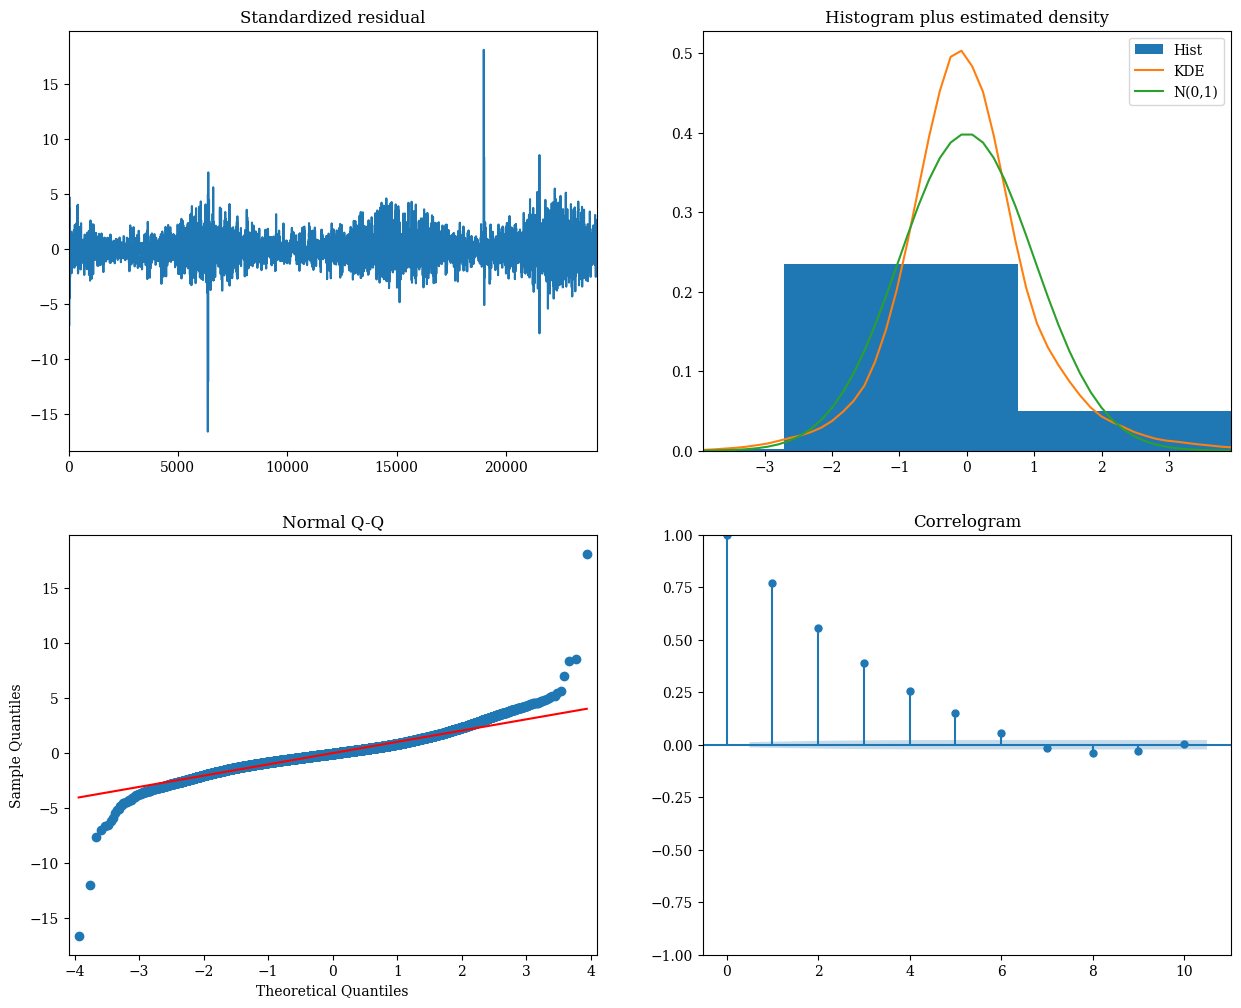

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                24172
Model:             SARIMAX(1, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood              -65982.495
Date:                                Mon, 29 Apr 2024   AIC                         131976.990
Time:                                        14:08:51   BIC                         132025.546
Sample:                                             0   HQIC                        131992.732
                                              - 24172                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9823      0.001   1410.959      0.000       0.981       0.984
ar.S.L7       -0.3641      0.006    -62.920      0.000      -0.375      -0.353
ar.S.L14      -0.5888      0.003   -178.871      0.000      -0.595      -0.582
ma.S.L7       -0.6305      0.006    -99.431      0.000      -0.643      -0.618
ma.S.L14      -0.2632      0.007    -38.660      0.000      -0.277      -0.250
sigma2        13.1086      0.049    266.992      0.000      13.012      13.205
===================================================================================
Ljung-Box (L1) (Q):               14260.43   Jarque-Bera (JB):            108089.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = auto_arima(
    data['Point_6_S_mean'],  # The time series to which the ARIMA model is fit.
    exogenous=data[['month', 'hour', 'day', 'Average_Global_Radiation_(1h)','PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']],  # The external variables to include in the model.
    start_p=1,  # This is the order of the AR term.
    start_q=1,  # This is the order of the MA term.
    test='adf',  # The type of unit root test to use in order to determine the order of differencing.
    max_p=3,  # The maximum value of p to try when fitting the model.
    max_q=3,  # The maximum value of q to try when fitting the model.
    m=7,  # The number of periods in each season. This affects the seasonal differencing.
    start_P=0,  # The starting value of P in auto_arima. This is the order of the seasonal AR term.
    seasonal=True,  # Whether to include seasonal differencing in the model.
    d=None,  # The order of first-differencing. If None, the value is automatically determined.
    D=1,  # The order of seasonal differencing.
    trace=True,  # Whether to print status on the fits.
    error_action='ignore',  # If a model cannot be fit, ignore the error and continue.
    suppress_warnings=True,  # If True, do not print warnings.
    stepwise=True,  # If True, use the stepwise algorithm to fit the model.
    maxiter=15  # The maximum number of function evaluations.
)

model.plot_diagnostics(figsize=(15, 12))
plt.show()
model.summary()

c:\Users\erlih\repos\HeroysundBridge-ML\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\erlih\repos\HeroysundBridge-ML\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


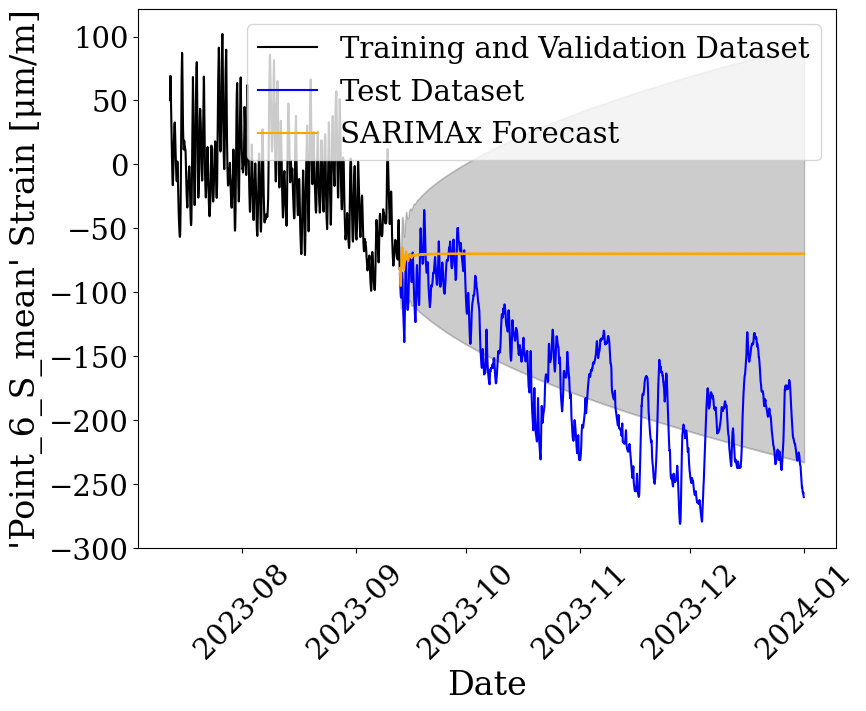

MSE: 12818.996673443953
MAE: 100.00367330567907
R2: -3.3696689143012035


In [ ]:
def forecast(model, periods=test_split):
    forecast, conf_int = model.predict(n_periods=periods, return_conf_int=True)
    
    forecast_index = pd.date_range(start=data.index[-1], periods=periods + 1, freq='H')[1:]
    lookback_variable = 500*3

    # Plotting
    plt.figure(figsize=(9, 7))
    plt.plot(df.index[(training_split+validation_split)-lookback_variable:-test_split], df['Point_6_S_mean'].iloc[(training_split+validation_split)-lookback_variable:-test_split], label='Training and Validation Dataset', color='black')
    plt.plot(df[-test_split:].index, df['Point_6_S_mean'][-test_split:], label='Test Dataset', color='blue')
    plt.plot(forecast_index, forecast, label='SARIMAx Forecast', color='orange')
    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.2) # Between the confidence intervals
    plt.xlabel("Date", fontsize=16*1.5)
    plt.ylabel("'Point_6_S_mean' Strain [μm/m]", fontsize=16*1.5)
    plt.xticks(rotation=45)
    plt.yticks(fontsize=14*1.5)
    plt.xticks(fontsize=14*1.5)
    plt.legend(fontsize=14*1.5)
    plt.show()

    test_df = df[-test_split:][['Point_6_S_mean']]
    forecast_values = forecast.to_numpy().flatten()
    test_values = test_df.to_numpy().flatten()
   
    print(f"MSE: {mean_squared_error(test_values, forecast_values)}")
    print(f"MAE: {mean_absolute_error(test_values, forecast_values)}")
    print(f"R2: {score(test_values, forecast_values)}")

forecast(model)

# Section for figures in baseline


Naive prediction

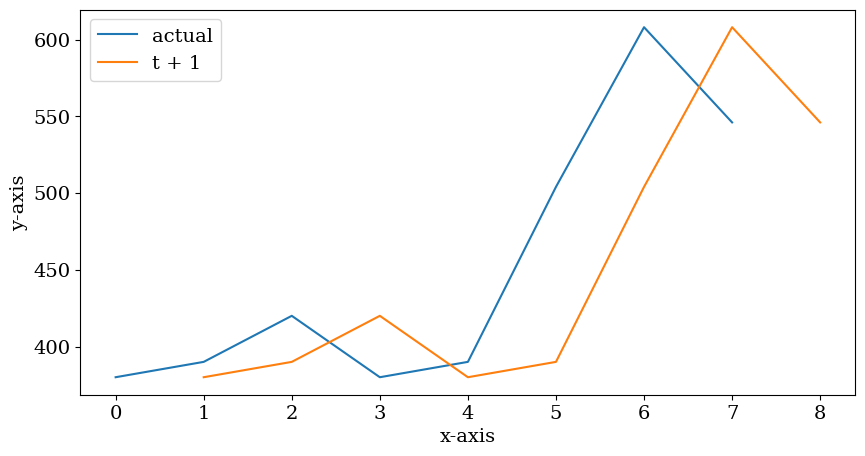

In [33]:
import pandas as pd

data = {
  "calories": [420, 380, 390, 420, 380, 390, 420*1.2, 380*1.6, 390*1.4, 420*2.3]
}

df1 = pd.DataFrame(data)
df2 = df1.shift(-1)

plt.figure(figsize=(10, 5))
plt.plot(df2['calories'][:-2], label='actual') 
plt.plot(df1['calories'][1:-1], label='t + 1')
plt.xlabel('x-axis', fontsize=14)
plt.ylabel('y-axis', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)

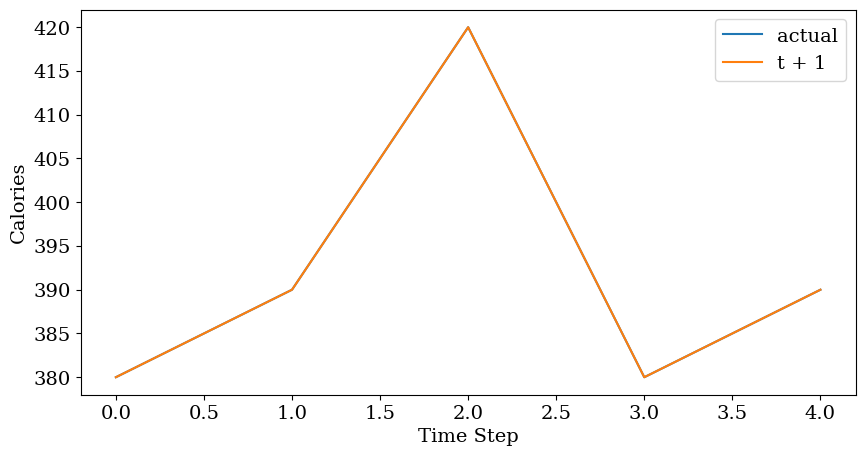

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
  "calories": [420, 380, 390, 420, 380, 390]
}

df1 = pd.DataFrame(data)
df2 = df1.shift(-1)

# Shift the 't + 1' series one step ahead
t_plus_1 = df1['calories'][1:].reset_index(drop=True)

# Concatenate 'actual' and 'None' value
actual = pd.concat([df2['calories'].dropna(), pd.Series([None])]).reset_index(drop=True)

plt.figure(figsize=(10, 5))
plt.plot(actual, label='actual') 
plt.plot(t_plus_1, label='t + 1')
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Calories', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

